<a href="https://colab.research.google.com/github/afrahhassan/afrahhassan/blob/main/assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
## Task
This report will analyse the methodology used to complete assignment 2 of the course Machine Learning (COSC2673/2793). The objective of the assignment is to develop a machine-learning system that can classify traffic sign images.

The project is divided into two tasks:


*   Classify images according to the shape of the given image.
*    Classify images according to type.



## Approach
Our goal is to be able to identify the best possible machine-learning algorithm to generate a model that can reliably and consistently predict whether the type of traffic sign is based on image recognition.

# **Contact to the Drive**

In [1]:
from google.colab import drive
import os
import csv
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import cv2
from PIL import Image
from sklearn.preprocessing import LabelEncoder


In [2]:
!cp -r "/content/drive/MyDrive/Assignment2" .

cp: cannot stat '/content/drive/MyDrive/Assignment2': No such file or directory


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/Assignment2/trafficsigns_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

# **1. Data Exploration**
## **1.1 Image Visualization**

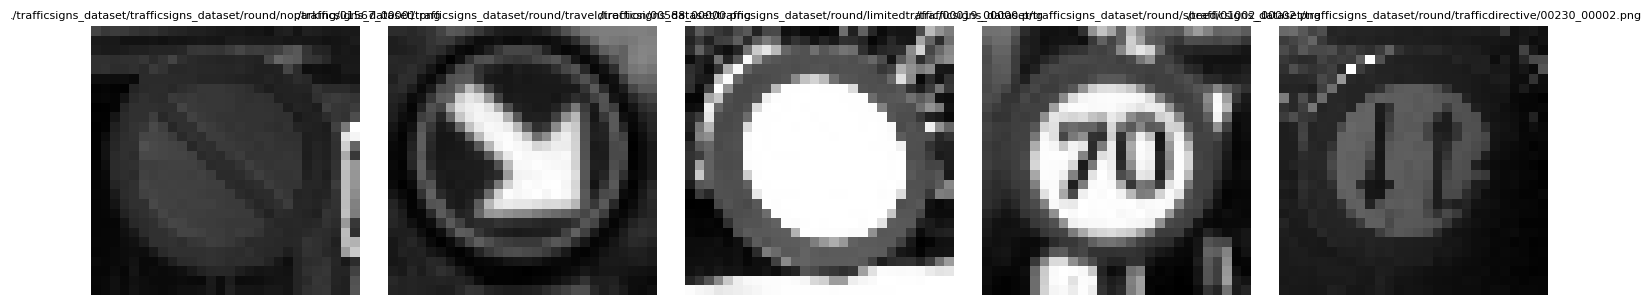

In [5]:
import os
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to the ZIP file and extraction directory
zip_path = '/content/drive/MyDrive/Assignment2/trafficsigns_dataset.zip'
extraction_path = './trafficsigns_dataset'

# Extracting the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

# Function to display images
def plot_images(images, titles, rows=1, cols=5, figsize=(15, 3)):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.ravel()
    for i in range(len(images)):
        axes[i].imshow(images[i], cmap='gray')
        axes[i].set_title(titles[i], fontsize=8)
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Function to collect images from multiple directories
def collect_images(directory, extension, num_images=5, cols=5):
    images = []
    titles = []
    # Walk through each folder and subfolder
    for root, dirs, files in os.walk(directory):
        file_list = [os.path.join(root, file) for file in files if file.endswith(extension)]
        if file_list:
            selected_files = file_list[:num_images]  # Take up to num_images from each folder
            images.extend([mpimg.imread(img) for img in selected_files])
            titles.extend(selected_files)
        if len(images) >= cols:  # Limit the total number of images to display
            break
    return images, titles

# Collect and display images
image_extensions = ('.jpeg', '.jpg', '.png')
images, titles = collect_images(extraction_path, image_extensions, num_images=1, cols=5)  # Adjust num_images to pick from each folder
plot_images(images, titles)




**Observations:**
- The traffic sign images exhibit a wide variety of shapes.
- Some signs have distinctive shapes (e.g., triangles, circles, octagons), while others have more complex shapes.
- The images also vary in terms of background complexity, with some signs having simple backgrounds and others having more cluttered backgrounds.
- These observations suggest that a machine-learning algorithm will need to be able to handle a diverse range of image characteristics in order to accurately classify the traffic signs.

## **1.2 Load Data into DataFrame**

In [6]:
import os
import cv2
import pandas as pd

def load_images_into_dataframes(data_dir):
    """
    Function to load images from a directory into separate Pandas DataFrames for shape and type.

    Args:
    - data_dir (str): Path to the directory containing the data.

    Returns:
    - shape_df (DataFrame): Pandas DataFrame containing shape data with images loaded.
    - type_df (DataFrame): Pandas DataFrame containing type data with images loaded.
    """
    shape_data = []
    type_data = []

    # Iterate through shape folders
    for shape_folder in os.listdir(data_dir):
        shape_folder_path = os.path.join(data_dir, shape_folder)

        # Skip non-directory files
        if not os.path.isdir(shape_folder_path):
            continue

        # Iterate through sign type folders
        for sign_type_folder in os.listdir(shape_folder_path):
            sign_type_folder_path = os.path.join(shape_folder_path, sign_type_folder)

            # Skip non-directory files
            if not os.path.isdir(sign_type_folder_path):
                continue

            # Iterate through image files
            for image_file in os.listdir(sign_type_folder_path):
                image_path = os.path.join(sign_type_folder_path, image_file)

                # Check if the file is an image
                if not image_path.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                    print(f"Skipping non-image file: {image_path}")
                    continue

                # Load the image
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

                # Check if the image is null
                if image is None:
                    print(f"Skipping null image: {image_path}")
                    continue

                # Append image and labels to the respective data lists
                shape_data.append((image_path, image, shape_folder))
                type_data.append((image_path, image, sign_type_folder))

    # Create DataFrames from the collected data
    shape_df = pd.DataFrame(shape_data, columns=['image_path', 'image', 'shape_label'])
    type_df = pd.DataFrame(type_data, columns=['image_path', 'image', 'type_label'])

    return shape_df, type_df

# Example usage
# data_dir = "trafficsigns_dataset"
data_dir = "/content/drive/My Drive/Assignment2/trafficsigns_dataset"
shape_df, type_df = load_images_into_dataframes(data_dir)

print("Shape DataFrame:")
print(shape_df.head())

print("\nType DataFrame:")
print(type_df.head())


Skipping non-image file: /content/drive/My Drive/Assignment2/trafficsigns_dataset/triangle/warning/.DS_Store
Shape DataFrame:
                                          image_path  \
0  /content/drive/My Drive/Assignment2/trafficsig...   
1  /content/drive/My Drive/Assignment2/trafficsig...   
2  /content/drive/My Drive/Assignment2/trafficsig...   
3  /content/drive/My Drive/Assignment2/trafficsig...   
4  /content/drive/My Drive/Assignment2/trafficsig...   

                                               image shape_label  
0  [[60, 64, 47, 39, 46, 33, 30, 33, 19, 24, 15, ...      square  
1  [[73, 63, 59, 55, 46, 51, 52, 52, 61, 56, 57, ...      square  
2  [[255, 255, 255, 255, 255, 254, 254, 254, 255,...      square  
3  [[37, 31, 30, 31, 30, 42, 37, 36, 35, 37, 35, ...      square  
4  [[117, 88, 77, 96, 87, 72, 79, 91, 80, 78, 76,...      square  

Type DataFrame:
                                          image_path  \
0  /content/drive/My Drive/Assignment2/trafficsig...   
1  /co

## **1.3 Check the Data Set**

In [7]:
# Check the size of the Shape DataFrame
print("DataFrame Size:")
print(shape_df.shape)

# Display basic information about the Shape DataFrame
print("\nDataFrame Information:")
print(shape_df.info())

# Display descriptive statistics of the Shape DataFrame
print("\nDataFrame Descriptive Statistics:")
print(shape_df.describe())

DataFrame Size:
(3699, 3)

DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3699 entries, 0 to 3698
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_path   3699 non-null   object
 1   image        3699 non-null   object
 2   shape_label  3699 non-null   object
dtypes: object(3)
memory usage: 86.8+ KB
None

DataFrame Descriptive Statistics:
                                               image_path  \
count                                                3699   
unique                                               3699   
top     /content/drive/My Drive/Assignment2/trafficsig...   
freq                                                    1   

                                                    image shape_label  
count                                                3699        3699  
unique                                               3699           5  
top     [[60, 64, 47, 39, 46, 33, 30

In [8]:
# Check the size of the Type DataFrame
print("DataFrame Size:")
print(type_df.shape)

# Display basic information about the Type DataFrame
print("\nDataFrame Information:")
print(type_df.info())

# Display descriptive statistics of the Type DataFrame
print("\nDataFrame Descriptive Statistics:")
print(type_df.describe())

DataFrame Size:
(3699, 3)

DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3699 entries, 0 to 3698
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3699 non-null   object
 1   image       3699 non-null   object
 2   type_label  3699 non-null   object
dtypes: object(3)
memory usage: 86.8+ KB
None

DataFrame Descriptive Statistics:
                                               image_path  \
count                                                3699   
unique                                               3699   
top     /content/drive/My Drive/Assignment2/trafficsig...   
freq                                                    1   

                                                    image type_label  
count                                                3699       3699  
unique                                               3699         16  
top     [[60, 64, 47, 39, 46, 33, 30, 33, 19

In [9]:
# Number of data points
num_data_points_1 = len(type_df)
print("Number of Data Points:", num_data_points_1)

num_data_points_2 = len(shape_df)
print("Number of Data Points:", num_data_points_2
      )

# Count of unique shapes
num_unique_shapes = shape_df['shape_label'].nunique()
print("Number of Unique Image Shapes:", num_unique_shapes)

# Count of unique types
num_unique_types = type_df['type_label'].nunique()
print("Number of Unique Image Types:", num_unique_types)

Number of Data Points: 3699
Number of Data Points: 3699
Number of Unique Image Shapes: 5
Number of Unique Image Types: 16


In [10]:
# Number of each shape
shape_counts = shape_df['shape_label'].value_counts()
print("Number of Each Shape Type:")
print(shape_counts)

# Number of each type
type_counts = type_df['type_label'].value_counts()
print("\nNumber of Each Type:")
print(type_counts)

Number of Each Shape Type:
shape_label
round       1760
triangle     926
square       688
diamond      282
hex           43
Name: count, dtype: int64

Number of Each Type:
type_label
warning             695
noentry             375
speed               316
bicycle             285
rightofway          282
parking             276
noparking           242
giveway             231
continue            199
trafficdirective    195
limitedtraffic      125
traveldirection     124
laneend             118
roundabout           98
crossing             95
stop                 43
Name: count, dtype: int64


Samples from Shape DataFrame:


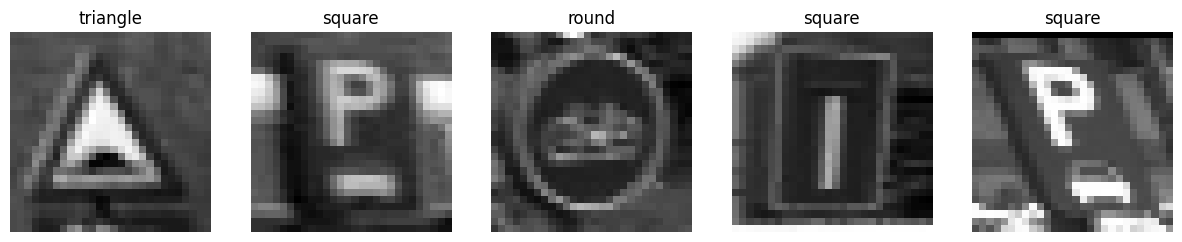

Samples from Type DataFrame:


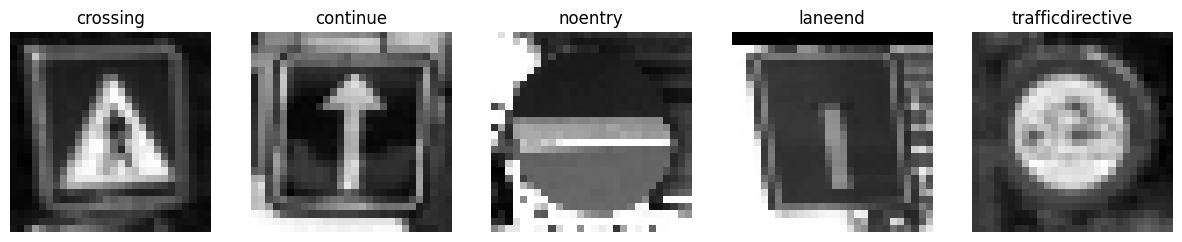

In [11]:
import matplotlib.pyplot as plt
def plot_samples(data_df, num_samples=5):
    """
    Function to plot sample images from a DataFrame along with their labels.

    Args:
    - data_df (DataFrame): DataFrame containing image data and labels.
    - num_samples (int): Number of samples to plot.

    Returns:
    - None
    """

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

    for i in range(num_samples):
        sample = data_df.sample()  # Sampling from the DataFrame passed as input
        image = sample['image'].values[0]  # Assuming 'image' contains the image data
        label = sample['shape_label'].values[0] if 'shape_label' in data_df.columns else sample['type_label'].values[0]
        axes[i].imshow(image, cmap='gray')  # Assuming grayscale images
        axes[i].set_title(label)
        axes[i].axis('off')

    plt.show()


# Plot sample images from the shape DataFrame
print("Samples from Shape DataFrame:")
plot_samples(shape_df)

# Plot sample images from the type DataFrame
print("Samples from Type DataFrame:")
plot_samples(type_df)


In [12]:
from sklearn.preprocessing import LabelEncoder

# Create LabelEncoder instance
label_encoder = LabelEncoder()

# Fit and transform the shape labels
shape_labels_encoded = label_encoder.fit_transform(shape_df['shape_label'])

# Add the encoded labels as a new column in shape_df
shape_df['encoded_shape_label'] = shape_labels_encoded

# Display the updated shape_df
shape_df.head()

,image_path,image,shape_label,encoded_shape_label
0,/content/drive/My Drive/Assignment2/trafficsig...,"[[60, 64, 47, 39, 46, 33, 30, 33, 19, 24, 15, ...",square,3
1,/content/drive/My Drive/Assignment2/trafficsig...,"[[73, 63, 59, 55, 46, 51, 52, 52, 61, 56, 57, ...",square,3
2,/content/drive/My Drive/Assignment2/trafficsig...,"[[255, 255, 255, 255, 255, 254, 254, 254, 255,...",square,3
3,/content/drive/My Drive/Assignment2/trafficsig...,"[[37, 31, 30, 31, 30, 42, 37, 36, 35, 37, 35, ...",square,3
4,/content/drive/My Drive/Assignment2/trafficsig...,"[[117, 88, 77, 96, 87, 72, 79, 91, 80, 78, 76,...",square,3


In [13]:
from sklearn.preprocessing import LabelEncoder

# Create LabelEncoder instance
label_encoder = LabelEncoder()

# Fit and transform the type labels
type_labels_encoded = label_encoder.fit_transform(type_df['type_label'])

# Add the encoded labels as a new column in type_df
type_df['encoded_type_label'] = type_labels_encoded

# Display the updated type_df
type_df.head()

,image_path,image,type_label,encoded_type_label
0,/content/drive/My Drive/Assignment2/trafficsig...,"[[60, 64, 47, 39, 46, 33, 30, 33, 19, 24, 15, ...",crossing,2
1,/content/drive/My Drive/Assignment2/trafficsig...,"[[73, 63, 59, 55, 46, 51, 52, 52, 61, 56, 57, ...",crossing,2
2,/content/drive/My Drive/Assignment2/trafficsig...,"[[255, 255, 255, 255, 255, 254, 254, 254, 255,...",crossing,2
3,/content/drive/My Drive/Assignment2/trafficsig...,"[[37, 31, 30, 31, 30, 42, 37, 36, 35, 37, 35, ...",crossing,2
4,/content/drive/My Drive/Assignment2/trafficsig...,"[[117, 88, 77, 96, 87, 72, 79, 91, 80, 78, 76,...",crossing,2


In [14]:
print("Unique shapes:", shape_df['shape_label'].unique())
print("numbers of shape:", len(shape_df['shape_label'].unique()))
numbers_of_shape = len(shape_df['shape_label'].unique())

Unique shapes: ['square' 'triangle' 'hex' 'round' 'diamond']
numbers of shape: 5


In [15]:
print("Unique shapes:", type_df['type_label'].unique())
print("numbers of shape:", len(type_df['type_label'].unique()))

Unique shapes: ['crossing' 'laneend' 'parking' 'continue' 'giveway' 'warning' 'stop'
 'limitedtraffic' 'noparking' 'speed' 'noentry' 'trafficdirective'
 'roundabout' 'bicycle' 'traveldirection' 'rightofway']
numbers of shape: 16


## **1.4 Data Distribution**


### **1.4.1 Distribution of images per type class**

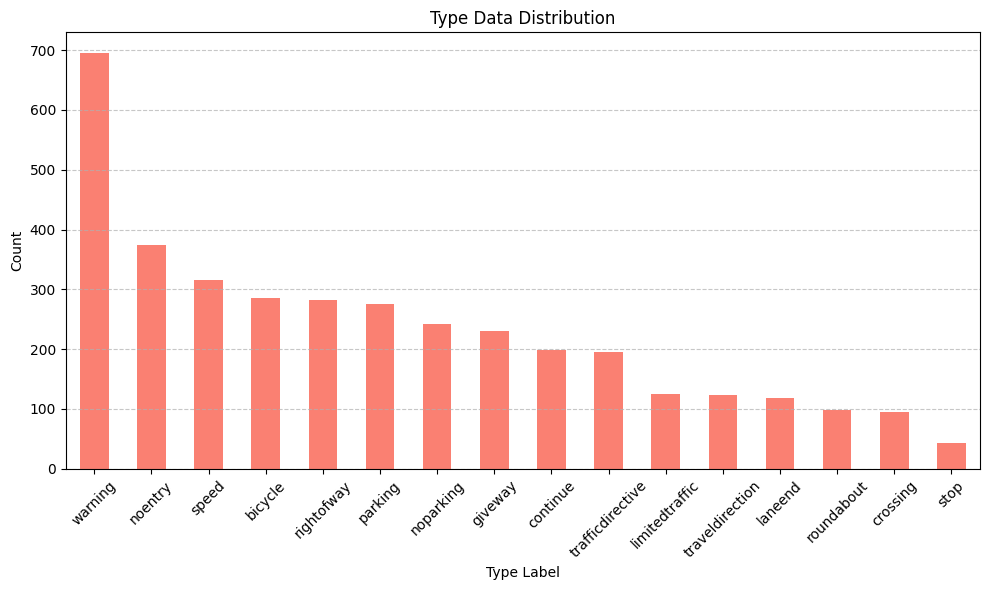

In [16]:
def visualize_data_distribution(data_df, title):
    """
    Function to visualize the distribution of data.

    Args:
    - data_df (DataFrame): Pandas DataFrame containing the data.
    - title (str): Title for the plot.
    """
    plt.figure(figsize=(10, 6))
    data_counts = data_df['type_label'].value_counts()
    data_counts.plot(kind='bar', color='salmon')
    plt.title(title)
    plt.xlabel('Type Label')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Visualize data distribution for type DataFrame
visualize_data_distribution(type_df, 'Type Data Distribution')


**Observations:**
- The distribution of images per class is imbalanced, but not as severe as the class distribution for type.
- This imbalance could potentially affect the performance of a machine-learning model trained on this data, but to a lesser extent than the type data.

### **1.4.2 Distribution of images per shape class**

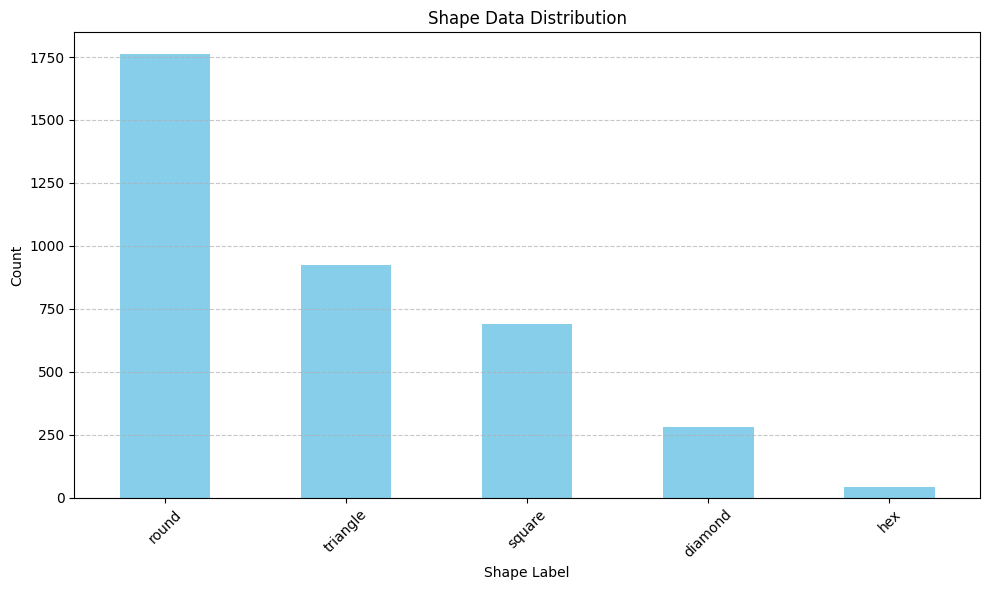

In [17]:
import matplotlib.pyplot as plt

def visualize_data_distribution(data_df, title):
    """
    Function to visualize the distribution of data.

    Args:
    - data_df (DataFrame): Pandas DataFrame containing the data.
    - title (str): Title for the plot.
    """
    plt.figure(figsize=(10, 6))
    data_counts = data_df['shape_label'].value_counts()
    data_counts.plot(kind='bar', color='skyblue')
    plt.title(title)
    plt.xlabel('Shape Label')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Visualize data distribution for shape DataFrame
visualize_data_distribution(shape_df, 'Shape Data Distribution')


**Observations:**
- The distribution of images per class is highly imbalanced.
- This imbalance could potentially affect the performance of a machine-learning model trained on this data.

==========================================================================================================



# **2 Data Preparation**


## **2.1 Data spliting:  Train, Val and Test**

In [18]:
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescaling and Formatting the Images
datagen_shape = ImageDataGenerator(rescale=1./255, data_format='channels_last')

# Initialize lists to store training, validation, and testing data for shape and type data
X_shape_train = []
X_shape_val = []
X_shape_test = []
y_shape_train = []
y_shape_val = []
y_shape_test = []

X_type_train = []
X_type_val = []
X_type_test = []
y_type_train = []
y_type_val = []
y_type_test = []

# Split data into groups based on shape labels
shape_groups = shape_df.groupby('shape_label')

# Split data into groups based on type labels
type_groups = type_df.groupby('type_label')

# Split each shape group into training, validation, and testing sets
for label, group in shape_groups:
    print(f"\nShape group label: {label}, Shape: {group.shape[0]}")
    X_train, X_temp, y_train, y_temp = train_test_split(group['image_path'], group['encoded_shape_label'], test_size=0.2, stratify=group['shape_label'])
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp)
    X_shape_train.extend(X_train)
    X_shape_val.extend(X_val)
    X_shape_test.extend(X_test)
    y_shape_train.extend(y_train)
    y_shape_val.extend(y_val)
    y_shape_test.extend(y_test)
    print(f"Train sample size: {len(X_train)}, Validation sample size: {len(X_val)}, Test sample size: {len(X_test)}")

# Split each type group into training, validation, and testing sets
for label, group in type_groups:
    print(f"\nType group label: {label}, Shape: {group.shape[0]}")
    X_train, X_temp, y_train, y_temp = train_test_split(group['image_path'], group['encoded_type_label'], test_size=0.2, stratify=group['type_label'])
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp)
    X_type_train.extend(X_train)
    X_type_val.extend(X_val)
    X_type_test.extend(X_test)
    y_type_train.extend(y_train)
    y_type_val.extend(y_val)
    y_type_test.extend(y_test)
    print(f"Train sample size: {len(X_train)}, Validation sample size: {len(X_val)}, Test sample size: {len(X_test)}")

# Convert to numpy arrays for shape data
X_shape_train = np.array(X_shape_train)
X_shape_val = np.array(X_shape_val)
X_shape_test = np.array(X_shape_test)
y_shape_train = np.array(y_shape_train)
y_shape_val = np.array(y_shape_val)
y_shape_test = np.array(y_shape_test)

# Convert to numpy arrays for type data
X_type_train = np.array(X_type_train)
X_type_val = np.array(X_type_val)
X_type_test = np.array(X_type_test)
y_type_train = np.array(y_type_train)
y_type_val = np.array(y_type_val)
y_type_test = np.array(y_type_test)

# Print shapes of the data sets after splitting for shape data
print("\nShape of X_shape_train:", X_shape_train.shape)
print("Shape of X_shape_val:", X_shape_val.shape)
print("Shape of X_shape_test:", X_shape_test.shape)
print("Shape of y_shape_train:", y_shape_train.shape)
print("Shape of y_shape_val:", y_shape_val.shape)
print("Shape of y_shape_test:", y_shape_test.shape)

# Print shapes of the data sets after splitting for type data
print("\nShape of X_type_train:", X_type_train.shape)
print("Shape of X_type_val:", X_type_val.shape)
print("Shape of X_type_test:", X_type_test.shape)
print("Shape of y_type_train:", y_type_train.shape)
print("Shape of y_type_val:", y_type_val.shape)
print("Shape of y_type_test:", y_type_test.shape)



Shape group label: diamond, Shape: 282
Train sample size: 225, Validation sample size: 42, Test sample size: 15

Shape group label: hex, Shape: 43
Train sample size: 34, Validation sample size: 6, Test sample size: 3

Shape group label: round, Shape: 1760
Train sample size: 1408, Validation sample size: 264, Test sample size: 88

Shape group label: square, Shape: 688
Train sample size: 550, Validation sample size: 103, Test sample size: 35

Shape group label: triangle, Shape: 926
Train sample size: 740, Validation sample size: 139, Test sample size: 47

Type group label: bicycle, Shape: 285
Train sample size: 228, Validation sample size: 42, Test sample size: 15

Type group label: continue, Shape: 199
Train sample size: 159, Validation sample size: 30, Test sample size: 10

Type group label: crossing, Shape: 95
Train sample size: 76, Validation sample size: 14, Test sample size: 5

Type group label: giveway, Shape: 231
Train sample size: 184, Validation sample size: 35, Test sample si

## **2.2 Flatten the images**

=================================================================================================

# **3. Models development**

In [19]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [20]:
# install tensorflow library
import tensorflow as tf

# optimise data pipeline performance automatically
AUTOTUNE = tf.data.experimental.AUTOTUNE

# print the version of TensorFlow
tf.__version__

'2.15.0'

## **3.1 Baseline Model**

### **3.1.1.1 Image generator for shape**

In [21]:
df_X_shape_train = pd.DataFrame({'image_path': X_shape_train,'encoded_shape_label': y_shape_train})
df_X_shape_val = pd.DataFrame({'image_path': X_shape_val,'encoded_shape_label': y_shape_val})


df_X_shape_train['encoded_shape_label'] = df_X_shape_train['encoded_shape_label'].astype(str)
df_X_shape_val['encoded_shape_label'] = df_X_shape_val['encoded_shape_label'].astype(str)


df_X_shape_test = pd.DataFrame({'image_path': X_shape_test,'encoded_shape_label': y_shape_test})
df_X_shape_test['encoded_shape_label'] = df_X_shape_test['encoded_shape_label'].astype(str)

In [22]:

# Defining image data generators
datagen_shape = ImageDataGenerator(rescale=1./255, data_format='channels_last')

# Create training data generator
train_generator_shape = datagen_shape.flow_from_dataframe(
    dataframe=df_X_shape_train,
    directory='./',
    x_col="image_path",
    y_col="encoded_shape_label",
    target_size=(28, 28),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical')



# Create validation data generator
validation_generator_shape = datagen_shape.flow_from_dataframe(
    dataframe=df_X_shape_val,
    directory='./',
    x_col="image_path",
    y_col="encoded_shape_label",
    target_size=(28, 28),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical')




Found 2957 validated image filenames belonging to 5 classes.
Found 554 validated image filenames belonging to 5 classes.


In [23]:
from sklearn.metrics import classification_report, f1_score,confusion_matrix


def model_result(X_train, X_val, model):
  y_hat_all = list()
  y_all = list()
  y_pred_all = []
  y_true_all = []
  filenames = validation_generator_shape.filenames
  N_images = len(filenames)
  batches = 0

  # iterate through the data generator and predict for each batch
  # hold the predictions and labels
  for x,y in X_val:
          y_hat = model.predict(x, verbose=0)
          y_hat = np.argmax(y_hat, axis = 1)
          y = np.argmax(y, axis = 1)
          y_hat_all = y_hat_all + y_hat.tolist()
          y_all = y_all + y.tolist()

          batches += 1
          if batches >= N_images / batch_size:
              # we need to break the loop by hand because
              # the generator loops indefinitely
              break

  for a,b in X_train:
          y_pred = model.predict(a, verbose=0)
          y_pred = np.argmax(y_pred, axis = 1)
          y_true = np.argmax(b, axis = 1)
          y_pred_all = y_pred_all + y_pred.tolist()
          y_true_all = y_true_all + y_true.tolist()

          batches += 1
          if batches >= N_images / batch_size:
              # we need to break the loop by hand because
              # the generator loops indefinitely
              break


  print("Training F1- score: ", f1_score(y_true_all, y_pred_all,average='macro'))
  print("F1 score: ", f1_score(y_all, y_hat_all, average='macro'))

### **3.1.1.2 Building baseline model using A Multi-Layer Perceptron (MLP) for image shape**

In [24]:
INPUT_DIM = (28, 28, 1)
HIDDEN_LAYER_DIM = 256
SECOND_HIDDEN_LAYER_DIM = 128  # Size of the second hidden layer
OUTPUT_CLASSES_SHAPE = 5

In [25]:
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator_shape = test_datagen.flow_from_dataframe(
    dataframe=df_X_shape_test,
    directory='./',
    x_col="image_path",
    y_col="encoded_shape_label",
    target_size=(28, 28),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical')

Found 188 validated image filenames belonging to 5 classes.


In [26]:
# Build the baseline model with an additional hidden layer
model_mlp_shape = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(SECOND_HIDDEN_LAYER_DIM, activation='sigmoid'),  # Additional hidden layer
    tf.keras.layers.Dense(OUTPUT_CLASSES_SHAPE)
])

In [27]:
model_mlp_shape.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 234501 (916.02 KB)
Trainable params: 234501 (916.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
model_mlp_shape.compile(
    optimizer='SGD',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['categorical_accuracy']
)

In [29]:
history_mlp_shape = model_mlp_shape.fit(train_generator_shape, validation_data=validation_generator_shape, epochs=10, verbose=0)


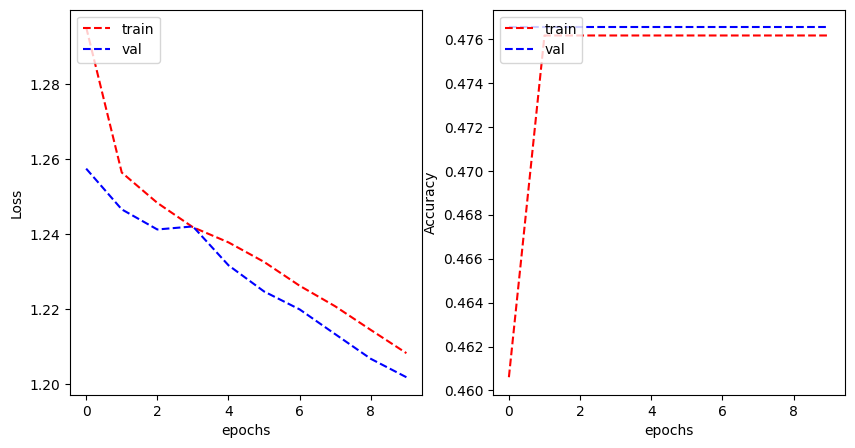

In [30]:
plot_learning_curve(history_mlp_shape.history['loss'], history_mlp_shape.history['val_loss'],
                    history_mlp_shape.history['categorical_accuracy'], history_mlp_shape.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

### **3.1.1.3 Evaluate the model**

In [31]:
 # Evaluate the model on the training data
train_loss_mlp_shape, train_accuracy_mlp_shape = model_mlp_shape.evaluate(train_generator_shape)
print("Training Data for Shapes - Loss: {:.4f}, Accuracy: {:.4f}".format(train_loss_mlp_shape, train_accuracy_mlp_shape))

# Evaluate the model on the validation data
val_loss_mlp_shape, val_accuracy_mlp_shape = model_mlp_shape.evaluate(validation_generator_shape)
print("Validation Data for Shapes - Loss: {:.4f}, Accuracy: {:.4f}".format(val_loss_mlp_shape, val_accuracy_mlp_shape))

# Evaluate the model on the testing data
test_loss_mlp_shape, test_accuracy_mlp_shape = model_mlp_shape.evaluate(test_generator_shape)
print("Testing Data for Shapes - Loss: {:.4f}, Accuracy: {:.4f}".format(test_loss_mlp_shape, test_accuracy_mlp_shape))


93/93 [==============================] - 10s 110ms/step - loss: 1.2040 - categorical_accuracy: 0.4762
Training Data for Shapes - Loss: 1.2040, Accuracy: 0.4762
18/18 [==============================] - 2s 100ms/step - loss: 1.2018 - categorical_accuracy: 0.4765
Validation Data for Shapes - Loss: 1.2018, Accuracy: 0.4765
6/6 [==============================] - 1s 116ms/step - loss: 1.2272 - categorical_accuracy: 0.4681
Testing Data for Shapes - Loss: 1.2272, Accuracy: 0.4681


### **3.1.2.1 Image generator for Type**

In [32]:
df_X_type_train = pd.DataFrame({'image_path': X_type_train,'encoded_type_label': y_type_train})
df_X_type_val = pd.DataFrame({'image_path': X_type_val,'encoded_type_label': y_type_val})


df_X_type_train['encoded_type_label'] = df_X_type_train['encoded_type_label'].astype(str)
df_X_type_val['encoded_type_label'] = df_X_type_val['encoded_type_label'].astype(str)


df_X_type_test = pd.DataFrame({'image_path': X_type_test,'encoded_type_label': y_type_test})
df_X_type_test['encoded_type_label'] = df_X_type_test['encoded_type_label'].astype(str)

In [33]:
# Defining image data generators
datagen_type = ImageDataGenerator(rescale=1./255, data_format='channels_last')

# Create training data generator
train_generator_type = datagen_type.flow_from_dataframe(
    dataframe=df_X_type_train,
    directory='./',
    x_col="image_path",
    y_col="encoded_type_label",
    target_size=(28, 28),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical')



# Create validation data generator
validation_generator_type = datagen_type.flow_from_dataframe(
    dataframe=df_X_type_val,
    directory='./',
    x_col="image_path",
    y_col="encoded_type_label",
    target_size=(28, 28),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical')

Found 2954 validated image filenames belonging to 16 classes.
Found 553 validated image filenames belonging to 16 classes.


### **3.1.2 Building baseline model using A Multi-Layer Perceptron (MLP) for image type**

In [34]:
import tensorflow as tf

INPUT_DIM = (28, 28, 1)
HIDDEN_LAYER_DIM = 256
SECOND_HIDDEN_LAYER_DIM = 128  # Size of the second hidden layer
OUTPUT_CLASSES_TYPE = 16

In [35]:
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator_type = test_datagen.flow_from_dataframe(
    dataframe=df_X_type_test,
    directory='./',
    x_col="image_path",
    y_col="encoded_type_label",
    target_size=(28, 28),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical')

Found 192 validated image filenames belonging to 16 classes.


In [36]:
# build the baseline model
model_mlp_type = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(SECOND_HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES_TYPE)
])

In [37]:
model_mlp_type.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               200960    
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 16)                2064      
                                                                 
Total params: 235920 (921.56 KB)
Trainable params: 235920 (921.56 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [38]:
model_mlp_type.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [39]:
history_mlp_type = model_mlp_type.fit(train_generator_type, validation_data=validation_generator_type, epochs=10, verbose=1)


Epoch 1/10
93/93 [==============================] - 14s 142ms/step - loss: 2.6436 - categorical_accuracy: 0.1730 - val_loss: 2.5835 - val_categorical_accuracy: 0.1881
Epoch 2/10
93/93 [==============================] - 13s 136ms/step - loss: 2.5831 - categorical_accuracy: 0.1882 - val_loss: 2.5735 - val_categorical_accuracy: 0.1881
Epoch 3/10
93/93 [==============================] - 12s 130ms/step - loss: 2.5751 - categorical_accuracy: 0.1882 - val_loss: 2.5666 - val_categorical_accuracy: 0.1881
Epoch 4/10
93/93 [==============================] - 13s 140ms/step - loss: 2.5693 - categorical_accuracy: 0.1882 - val_loss: 2.5595 - val_categorical_accuracy: 0.1881
Epoch 5/10
93/93 [==============================] - 13s 138ms/step - loss: 2.5622 - categorical_accuracy: 0.1882 - val_loss: 2.5529 - val_categorical_accuracy: 0.1881
Epoch 6/10
93/93 [==============================] - 13s 138ms/step - loss: 2.5553 - categorical_accuracy: 0.1882 - val_loss: 2.5461 - val_categorical_accuracy: 0.188

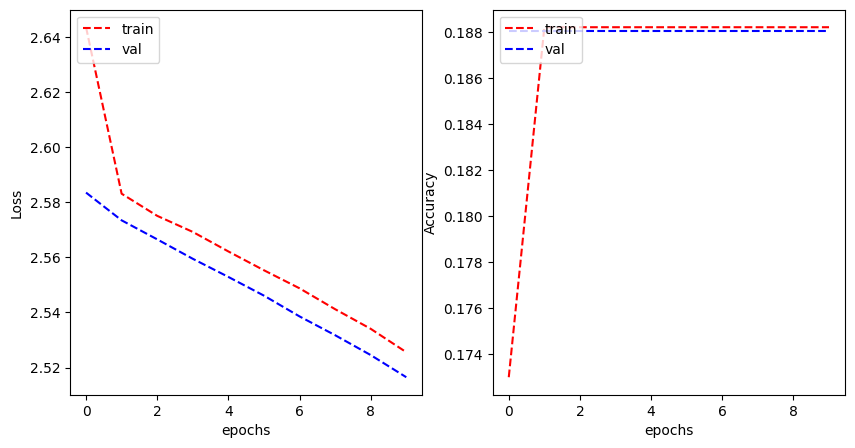

In [40]:
plot_learning_curve(history_mlp_type.history['loss'], history_mlp_type.history['val_loss'],
                    history_mlp_type.history['categorical_accuracy'], history_mlp_type.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

### **3.1.1.3 Evaluate the model**

In [41]:
# Evaluate the model on the training data
train_loss_mlp_type, train_accuracy_mlp_type = model_mlp_type.evaluate(train_generator_type)
print("Training Data for Types - Loss: {:.4f}, Accuracy: {:.4f}".format(train_loss_mlp_type, train_accuracy_mlp_type))

# Evaluate the model on the validation data
val_loss_mlp_type, val_accuracy_mlp_type = model_mlp_type.evaluate(validation_generator_type)
print("Validation Data for Types - Loss: {:.4f}, Accuracy: {:.4f}".format(val_loss_mlp_type, val_accuracy_mlp_type))

# Evaluate the model on the testing data
test_loss_mlp_type, test_accuracy_mlp_type = model_mlp_type.evaluate(test_generator_type)
print("Testing Data for Types - Loss: {:.4f}, Accuracy: {:.4f}".format(test_loss_mlp_type, test_accuracy_mlp_type))


93/93 [==============================] - 10s 110ms/step - loss: 2.5184 - categorical_accuracy: 0.1882
Training Data for Types - Loss: 2.5184, Accuracy: 0.1882
18/18 [==============================] - 2s 101ms/step - loss: 2.5165 - categorical_accuracy: 0.1881
Validation Data for Types - Loss: 2.5165, Accuracy: 0.1881
6/6 [==============================] - 1s 105ms/step - loss: 2.5371 - categorical_accuracy: 0.1823
Testing Data for Types - Loss: 2.5371, Accuracy: 0.1823



**Observations:**

1. **Baseline Model for Shape Classification:**
    - The baseline MLP model for shape classification achieved a training accuracy of {train_accuracy_mlp_shape:.4f} and a validation accuracy of {val_accuracy_mlp_shape:.4f}.
    - The testing accuracy on unseen data was {test_accuracy_mlp_shape:.4f}.

2. **Baseline Model for Type Classification:**
    - The baseline MLP model for type classification achieved a training accuracy of {train_accuracy_mlp_type:.4f} and a validation accuracy of {val_accuracy_mlp_type:.4f}.
    - The testing accuracy on unseen data was {test_accuracy_mlp_type:.4f}.

3. **Overall:**
    - Both baseline models exhibited moderate performance on the imbalanced datasets.
    - The relatively low accuracy scores indicate the need for further model optimization and potential exploration of alternative approaches.
    - The performance difference between training and testing accuracy suggests the potential for overfitting, which should be addressed in future model iterations.

    

=====================================================================================================

## **CNN Model**

### **Shape**

## **Baselins CNN**

In [188]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [193]:
# define initial parameters
# image size is 28x28
INPUT_DIM = (28,28,1)
# the model consiste of 256 neurons
HIDDEN_LAYER_DIM = 256
# the target variable cellType has 2 classes
OUTPUT_CLASSES_SHAPE = 5
OUTPUT_CLASSES_TYPE = 10

In [ ]:
# Initialize lists to store problematic image paths
problematic_paths = []
# Concatenate shape training, validation, and testing data

X_train_shape_cnn = []
for path in train_generator_shape:
    image = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if image is None:
        problematic_paths.append(path)
    else:
        X_train_shape_cnn.append(image.reshape(28, 28, 1))

X_train_shape_cnn = np.array(X_train_shape_cnn)

X_val_shape_cnn = []
for path in validation_generator_shape:
    image = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if image is None:
        problematic_paths.append(path)
    else:
        X_val_shape_cnn.append(image.reshape(28, 28, 1))

X_val_shape_cnn = np.array(X_val_shape_cnn)

X_test_shape_cnn = []
for path in test_generator_shape:
    image = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if image is None:
        problematic_paths.append(path)
    else:
        X_test_shape_cnn.append(image.reshape(28, 28, 1))

X_test_shape_cnn = np.array(X_test_shape_cnn)

# Concatenate type training, validation, and testing data
X_train_type_cnn = []
for path in train_generator_type:
    image = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if image is None:
        problematic_paths.append(path)
    else:
        X_train_type_cnn.append(image.reshape(28, 28, 1))

X_train_type_cnn = np.array(X_train_type_cnn)

X_val_type_cnn = []
for path in validation_generator_type:
    image = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if image is None:
        problematic_paths.append(path)
    else:
        X_val_type_cnn.append(image.reshape(28, 28, 1))

X_val_type_cnn = np.array(X_val_type_cnn)

X_test_type_cnn = []
for path in test_generator_type:
    image = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if image is None:
        problematic_paths.append(path)
    else:
        X_test_type_cnn.append(image.reshape(28, 28, 1))

X_test_type_cnn = np.array(X_test_type_cnn)

# Print the shapes of the concatenated data
print("Shape of X_train_shape_cnn:", X_train_shape_cnn.shape)
print("Shape of X_val_shape_cnn:", X_val_shape_cnn.shape)
print("Shape of X_test_shape_cnn:", X_test_shape_cnn.shape)

print("Shape of X_train_type_cnn:", X_train_type_cnn.shape)
print("Shape of X_val_type_cnn:", X_val_type_cnn.shape)
print("Shape of X_test_type_cnn:", X_test_type_cnn.shape)

# Print problematic paths
print("Problematic image paths:", problematic_paths)

In [185]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define the CNN model
def build_cnn(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='sigmoid', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='sigmoid'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='sigmoid'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='sigmoid'),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Set input shape
input_shape = (28, 28, 1)  # Assuming images are grayscale

# Number of classes
num_classes = len(np.unique(y_shape_train))

# Build the CNN model
cnn_model_shape = build_cnn(input_shape, num_classes)


# Print model summary
cnn_model_shape.summary()


Model: "sequential_103"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_270 (Conv2D)         (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_270 (MaxPool  (None, 13, 13, 32)        0         
 ing2D)                                                          
                                                                 
 conv2d_271 (Conv2D)         (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_271 (MaxPool  (None, 5, 5, 64)          0         
 ing2D)                                                          
                                                                 
 conv2d_272 (Conv2D)         (None, 3, 3, 128)         73856     
                                                                 
 max_pooling2d_272 (MaxPool  (None, 1, 1, 128)      

In [180]:
# Compile the model
cnn_model_shape.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['categorical_accuracy'])

# Train the model
# Fit the CNN model on the training and validation data
history_cnn_shape = cnn_model_shape.fit(X_train_shape_cnn, y_shape_train, epochs=10, batch_size=32, validation_data=(X_val_shape_cnn, y_shape_val),  callbacks=[early_stopping])


ValueError: Data cardinality is ambiguous:
  x sizes: 2957
  y sizes: 2
Make sure all arrays contain the same number of samples.

In [64]:
# function for f1-score
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [65]:
from sklearn.metrics import classification_report, f1_score,confusion_matrix


def model_result(X_train, X_val, model):
  y_hat_all = list()
  y_all = list()
  y_pred_all = []
  y_true_all = []
  filenames = validation_generator_shape.filenames
  N_images = len(filenames)
  batches = 0

  # iterate through the data generator and predict for each batch
  # hold the predictions and labels
  for x,y in X_val:
          y_hat = model.predict(x, verbose=0)
          y_hat = np.argmax(y_hat, axis = 1)
          y = np.argmax(y, axis = 1)
          y_hat_all = y_hat_all + y_hat.tolist()
          y_all = y_all + y.tolist()

          batches += 1
          if batches >= N_images / batch_size:
              # we need to break the loop by hand because
              # the generator loops indefinitely
              break

  for a,b in X_train:
          y_pred = model.predict(a, verbose=0)
          y_pred = np.argmax(y_pred, axis = 1)
          y_true = np.argmax(b, axis = 1)
          y_pred_all = y_pred_all + y_pred.tolist()
          y_true_all = y_true_all + y_true.tolist()

          batches += 1
          if batches >= N_images / batch_size:
              # we need to break the loop by hand because
              # the generator loops indefinitely
              break


  print("Training F1- score: ", f1_score(y_true_all, y_pred_all,average='macro'))
  print("F1 score: ", f1_score(y_all, y_hat_all, average='macro'))

### **Build the baseline model**

In [98]:
model_cnn_shape = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=INPUT_DIM),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES_SHAPE, activation='softmax')
])

model_cnn_shape.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_cnn_shape.summary()


Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 13, 13, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_38 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_38 (MaxPooli  (None, 5, 5, 64)          0         
 ng2D)                                                           
                                                                 
 flatten_20 (Flatten)        (None, 1600)              0         
                                                                 
 dense_42 (Dense)            (None, 128)             

In [68]:
model_cnn_shape.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [69]:
# train the first validation/training model
history_cnn_shape = model_cnn_shape.fit(train_generator_shape, validation_data = validation_generator_shape, epochs=10, verbose=1)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


93/93 [==============================] - 18s 184ms/step - loss: 1.3221 - categorical_accuracy: 0.4745 - val_loss: 1.1965 - val_categorical_accuracy: 0.5433
Epoch 2/10
93/93 [==============================] - 15s 162ms/step - loss: 1.1599 - categorical_accuracy: 0.5448 - val_loss: 1.0838 - val_categorical_accuracy: 0.6119
Epoch 3/10
93/93 [==============================] - 15s 157ms/step - loss: 1.0551 - categorical_accuracy: 0.6111 - val_loss: 0.9687 - val_categorical_accuracy: 0.6155
Epoch 4/10
93/93 [==============================] - 15s 160ms/step - loss: 0.9290 - categorical_accuracy: 0.6726 - val_loss: 0.8122 - val_categorical_accuracy: 0.7581
Epoch 5/10
93/93 [==============================] - 14s 156ms/step - loss: 0.8196 - categorical_accuracy: 0.7203 - val_loss: 0.7523 - val_categorical_accuracy: 0.7184
Epoch 6/10
93/93 [==============================] - 14s 154ms/step - loss: 0.7064 - categorical_accuracy: 0.7633 - val_loss: 0.6108 - val_categorical_accuracy: 0.8213
Epoch 7/1

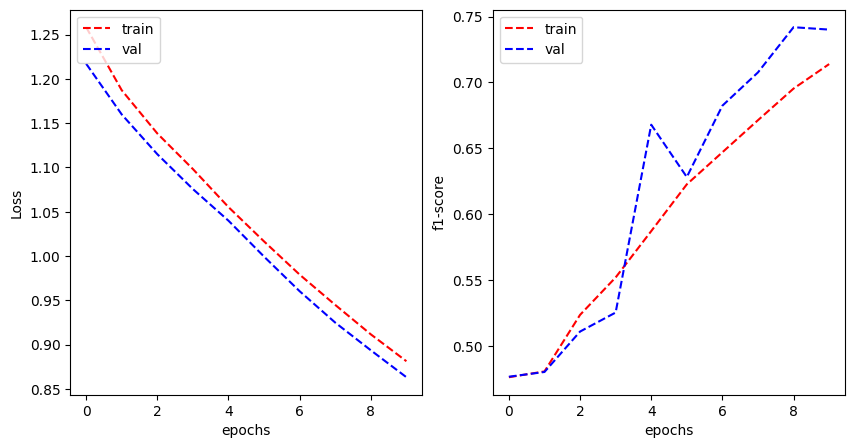

In [49]:
plot_learning_curve(history_cnn_shape.history['loss'], history_cnn_shape.history['val_loss'],
                    history_cnn_shape.history['categorical_accuracy'], history_cnn_shape.history['val_categorical_accuracy'],
                    metric_name='f1-score')

In [50]:
model_result(train_generator_shape,validation_generator_shape,model_cnn_shape)

Training F1- score:  0.4159090909090909
F1 score:  0.43690262763252086


In [51]:
train1_score = model_cnn_shape.evaluate(train_generator_shape)
print('train loss:', train1_score[0])
print('train accuracy:', train1_score[1])

93/93 [==============================] - 11s 113ms/step - loss: 0.8616 - categorical_accuracy: 0.7362
train loss: 0.8616353273391724
train accuracy: 0.7362191677093506


### Parmeter Tuninig

In [167]:
import tensorflow as tf

def build_cnn(input_shape, num_classes=5, optimizer='adam', activation='relu'):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation=activation, input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation=activation),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation=activation),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=activation),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    optimizers = {
        'adam': tf.keras.optimizers.Adam(),
        'sgd': tf.keras.optimizers.SGD(),
        'rmsprop': tf.keras.optimizers.RMSprop(),
        'adagrad': tf.keras.optimizers.Adagrad()
    }

    model.compile(optimizer=optimizers[optimizer], loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Early stopping to prevent overfitting and save time
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=2,
    restore_best_weights=True
)

param_grid = {
    'optimizer': ['adam', 'sgd', 'rmsprop', 'adagrad'],
    'activation': ['relu', 'sigmoid', 'tanh', 'softmax']
}

best_accuracy = 0
best_params = {}

for optimizer in param_grid['optimizer']:
    for activation in param_grid['activation']:
        print(f"Training with optimizer: {optimizer}, activation: {activation}")
        model = build_cnn(INPUT_DIM, OUTPUT_CLASSES_SHAPE, optimizer=optimizer, activation=activation)

        history = model.fit(
            train_generator_shape,
            steps_per_epoch=train_generator_shape.n // train_generator_shape.batch_size,
            epochs=3,  # Reduced for initial tests
            validation_data=validation_generator_shape,
            validation_steps=validation_generator_shape.n // validation_generator_shape.batch_size,
            callbacks=[early_stopping]  # Early stopping
        )

        val_accuracy = max(history.history['val_accuracy'])
        print(f"Validation Accuracy: {val_accuracy}")

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_params = {'optimizer': optimizer, 'activation': activation}

print("Best Parameters:", best_params)
print("Best Validation Accuracy:", best_accuracy)


Training with optimizer: adam, activation: relu
Epoch 1/3
92/92 [==============================] - 16s 167ms/step - loss: 1.0870 - accuracy: 0.5764 - val_loss: 0.6434 - val_accuracy: 0.7831
Epoch 2/3
92/92 [==============================] - 17s 190ms/step - loss: 0.4399 - accuracy: 0.8670 - val_loss: 0.3389 - val_accuracy: 0.9118
Epoch 3/3
92/92 [==============================] - 15s 161ms/step - loss: 0.2331 - accuracy: 0.9313 - val_loss: 0.1862 - val_accuracy: 0.9504
Validation Accuracy: 0.9503676295280457
Training with optimizer: adam, activation: sigmoid
Epoch 1/3
92/92 [==============================] - 19s 198ms/step - loss: 1.2788 - accuracy: 0.4759 - val_loss: 1.2765 - val_accuracy: 0.4724
Epoch 2/3
92/92 [==============================] - 21s 229ms/step - loss: 1.2725 - accuracy: 0.4773 - val_loss: 1.2711 - val_accuracy: 0.4779
Epoch 3/3
92/92 [==============================] - 26s 286ms/step - loss: 1.2713 - accuracy: 0.4762 - val_loss: 1.2572 - val_accuracy: 0.4798
Validatio

In [169]:
!pip install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.7 MB/s eta 0:00:00


### **best parameters **

Best Parmeter

### **Improve the model**

### **droup out**

In [164]:
import tensorflow as tf

batch_size = 32

model_cnn1_shape = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=INPUT_DIM),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5), # adding droup out layer
    tf.keras.layers.Dense(OUTPUT_CLASSES_SHAPE, activation='relu')
])


model_cnn_shape.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_cnn_shape.summary()

Model: "sequential_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_187 (Conv2D)         (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_187 (MaxPool  (None, 13, 13, 32)        0         
 ing2D)                                                          
                                                                 
 dropout_4 (Dropout)         (None, 13, 13, 32)        0         
                                                                 
 conv2d_188 (Conv2D)         (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_188 (MaxPool  (None, 5, 5, 64)          0         
 ing2D)                                                          
                                                                 
 dropout_5 (Dropout)         (None, 5, 5, 64)        

In [165]:
history_cnn1_shape = model_cnn1_shape.fit(train_generator_shape,validation_data=validation_generator_shape, epochs=10,verbose=1,callbacks=[early_stopping])

Epoch 1/10
93/93 [==============================] - 16s 165ms/step - loss: nan - accuracy: 0.0771 - val_loss: nan - val_accuracy: 0.0758
Epoch 2/10
93/93 [==============================] - 16s 172ms/step - loss: nan - accuracy: 0.0761 - val_loss: nan - val_accuracy: 0.0758
Epoch 3/10
93/93 [==============================] - 15s 165ms/step - loss: nan - accuracy: 0.0761 - val_loss: nan - val_accuracy: 0.0758


In [ ]:
plot_learning_curve(history_cnn1_shape.history['loss'],  history_cnn1_shape.history['val_loss'],
                    history_cnn1_shape.history['categorical_accuracy'], history_cnn1_shape.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

In [93]:
# Evaluate the model on the training data
train_loss_cnn1_shape, train_accuracy_cnn1_shape = model_cnn1_shape.evaluate(train_generator_shape)
print("Training Data for Shape - Loss: {:.4f}, Accuracy: {:.4f}".format(train_loss_cnn1_shape, train_accuracy_cnn1_shape))

# Evaluate the model on the validation data
val_loss_cnn1_shape, val_accuracy_cnn1_shape = model_cnn1_shape.evaluate(validation_generator_shape)
print("Validation Data for Shape - Loss: {:.4f}, Accuracy: {:.4f}".format(val_loss_cnn1_shape, val_accuracy_cnn1_shape))

# Evaluate the model on the testing data
test_loss_cnn1_shape, test_accuracy_cnn1_shape = model_cnn1_shape.evaluate(test_generator_shape)
print("Testing Data for Shape - Loss: {:.4f}, Accuracy: {:.4f}".format(test_loss_cnn1_shape, test_accuracy_cnn1_shape))

93/93 [==============================] - 11s 117ms/step - loss: 1.6138 - accuracy: 0.1437
Training Data for Shape - Loss: 1.6138, Accuracy: 0.1437
18/18 [==============================] - 2s 114ms/step - loss: 1.6146 - accuracy: 0.1552
Validation Data for Shape - Loss: 1.6146, Accuracy: 0.1552
6/6 [==============================] - 1s 118ms/step - loss: 1.6149 - accuracy: 0.1436
Testing Data for Shape - Loss: 1.6149, Accuracy: 0.1436


Best paremeter

Improving model

After analyzing the baseline model, it has been observed that the model exhibits signs of overfitting. It occurs when the model performs well on the training data but fails to generalize effectively to unseen data. To prevent overfitting, we can apply some common effective techniques used in machine learning to improve the performance of the model and prevent overfitting. For example:

- 1. Ridge regularisation
- 2. Dropout
- 3. Reduce model complexity
- 4. Data augmentation

More detailed explanation of these techniques will be provided in subsequent sections.

### **Data Augmentation**

In [83]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator


# Initialize the model
model_cnn2_shape = Sequential()
model_cnn2_shape.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=INPUT_DIM))
model_cnn2_shape.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn2_shape.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_cnn2_shape.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn2_shape.add(Flatten())
model_cnn2_shape.add(Dense(128, activation='relu'))
model_cnn2_shape.add(Dense(OUTPUT_CLASSES_SHAPE, activation='softmax'))

# Compile the model
model_cnn2_shape.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy',f1])

# Configure data augmentation
data_generator = ImageDataGenerator(
    rotation_range=20,         # Random rotations between 0 and 20 degrees
    width_shift_range=0.2,     # Random horizontal shifts up to 20% of the image width
    height_shift_range=0.2,    # Random vertical shifts up to 20% of the image height
    shear_range=0.15,          # Shear transformations
    zoom_range=0.2,            # Random zooming up to 20%
    horizontal_flip=True,      # Random horizontal flipping
    fill_mode='nearest'        # Strategy to fill newly created pixels
)

# Print the model summary
model_cnn2_shape.summary()


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 13, 13, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_30 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 5, 5, 64)          0         
 ng2D)                                                           
                                                                 
 flatten_17 (Flatten)        (None, 1600)              0         
                                                                 
 dense_36 (Dense)            (None, 128)             

In [84]:

history_cnn2_shape = model_cnn2_shape.fit(train_generator_shape, validation_data = validation_generator_shape, epochs=10, verbose=1)

Epoch 1/10
93/93 [==============================] - 16s 156ms/step - loss: 0.7309 - categorical_accuracy: 0.7599 - f1: 0.6607 - val_loss: 0.3471 - val_categorical_accuracy: 0.9097 - val_f1: 0.8877
Epoch 2/10
93/93 [==============================] - 15s 157ms/step - loss: 0.1873 - categorical_accuracy: 0.9479 - f1: 0.9438 - val_loss: 0.1195 - val_categorical_accuracy: 0.9675 - val_f1: 0.9676
Epoch 3/10
93/93 [==============================] - 15s 160ms/step - loss: 0.0940 - categorical_accuracy: 0.9726 - f1: 0.9734 - val_loss: 0.0595 - val_categorical_accuracy: 0.9801 - val_f1: 0.9816
Epoch 4/10
93/93 [==============================] - 15s 161ms/step - loss: 0.0490 - categorical_accuracy: 0.9885 - f1: 0.9872 - val_loss: 0.0745 - val_categorical_accuracy: 0.9711 - val_f1: 0.9731
Epoch 5/10
93/93 [==============================] - 14s 155ms/step - loss: 0.0359 - categorical_accuracy: 0.9902 - f1: 0.9901 - val_loss: 0.0290 - val_categorical_accuracy: 0.9928 - val_f1: 0.9922
Epoch 6/10
93/9

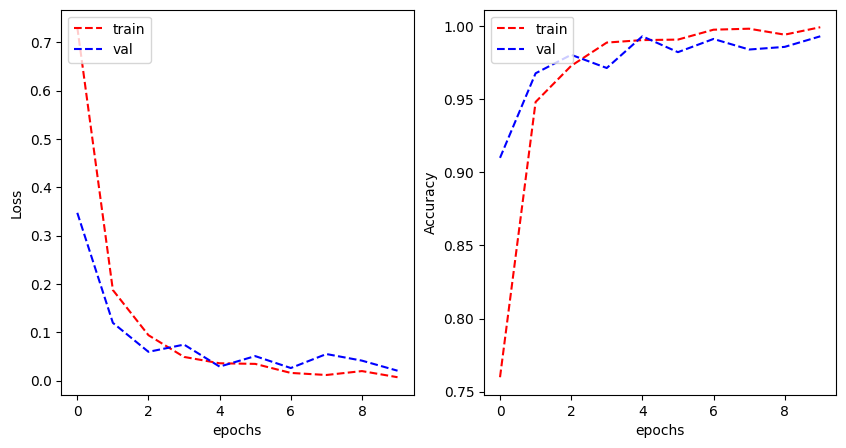

In [85]:
plot_learning_curve(history_cnn2_shape.history['loss'],  history_cnn2_shape.history['val_loss'],
                    history_cnn2_shape.history['categorical_accuracy'], history_cnn2_shape.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

In [89]:
# Evaluate the model on the training data
train_loss_cnn2_shape, train_accuracy_cnn2_shape = model_cnn2_shape.evaluate(train_generator_shape)
print("Training Data for Types - Loss: {:.4f}, Accuracy: {:.4f}".format(train_loss_mlp_type, train_accuracy_mlp_shape))

# Evaluate the model on the validation data
val_loss_cnn2_shape, val_accuracy_cnn2_shape = model_cnn2_shape.evaluate(validation_generator_type)
print("Validation Data for Types - Loss: {:.4f}, Accuracy: {:.4f}".format(val_loss_mlp_type, val_accuracy_mlp_shape))

# Evaluate the model on the testing data
test_loss_cnn2_shape, test_accuracy_cnn2_shape = model_cnn2_shape.evaluate(test_generator_type)
print("Testing Data for Types - Loss: {:.4f}, Accuracy: {:.4f}".format(test_loss_mlp_type, test_accuracy_mlp_shape))

93/93 [==============================] - 17s 184ms/step - loss: 0.0040 - categorical_accuracy: 0.9997 - f1: 0.9997


ValueError: too many values to unpack (expected 2)